In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\"
         + "OpenClassrooms\\Segmentez des clients d'un site e-commerce")
os.getcwd()

from functions import *

# Lecture du fichier issu de l'analyse exploratoire
clients = pd.read_csv("client_infos.csv")

In [2]:
clients.shape

(96093, 31)

In [3]:
clients.head()

,vouchers_value,boleto_value,debit_card_value,sum_payments,sum_freight_value,nb_items,fashion,diy,home,hightech,...,avg_review_len,avg_popularite,avg_product_name_lenght,avg_product_description_lenght,avg_product_photos_qty,max_order_timestamp,min_order_timestamp,time_since_last_order,time_since_first_order,delivery_time
0,0.0,0.0,0.0,141.90,12.00,1.0,0.0,0.0,1.0,0.0,...,111.0,2.408850,60.0,236.0,1.0,1.525950e+09,1.525950e+09,160,160,553930.0
1,0.0,0.0,0.0,27.19,8.29,1.0,1.0,0.0,0.0,0.0,...,0.0,0.337230,56.0,635.0,1.0,1.525691e+09,1.525691e+09,163,163,283875.0
2,0.0,0.0,0.0,86.22,17.22,1.0,0.0,0.0,1.0,0.0,...,0.0,0.148901,49.0,177.0,3.0,1.489180e+09,1.489180e+09,585,585,2223224.0
3,0.0,0.0,0.0,43.62,17.63,1.0,0.0,0.0,0.0,1.0,...,12.0,-0.039428,43.0,1741.0,5.0,1.507840e+09,1.507840e+09,369,369,1731204.0
4,0.0,0.0,0.0,196.89,16.89,1.0,0.0,0.0,0.0,1.0,...,0.0,-0.227757,58.0,794.0,3.0,1.510689e+09,1.510689e+09,336,336,1135394.0


In [4]:
clients.dtypes

vouchers_value                    float64
boleto_value                      float64
debit_card_value                  float64
sum_payments                      float64
sum_freight_value                 float64
nb_items                          float64
fashion                           float64
diy                               float64
home                              float64
hightech                          float64
culture                           float64
leisure                           float64
games                             float64
food                              float64
misc                              float64
nb_orders                           int64
nb_week_orders                      int64
nb_weekend_orders                   int64
favorite_dayofweek                  int64
favorite_hour                       int64
avg_review_score                  float64
avg_review_len                    float64
avg_popularite                    float64
avg_product_name_lenght           

La segmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour les actions de marketing direct des véadistes et qui s'applique désormais également aux acteurs du e-commerce et du commerce traditionnel.

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.

Dans notre jeu de données, on a donc :
- la Récence qui correspond à notre colonne 'time_since_last_order'.
- la Fréquence qui correspond à notre colonne 'nb_orders'.
- le Montant qui correspond à notre colonne 'sum_payments'.

On renomme les colonnes, et pour chacune de ces variables on va vérifier la distribution.

In [5]:
clients.rename(columns = {
    'time_since_last_order': 'recence',
    'nb_orders': 'frequence',
    'sum_payments': 'montant'
}, inplace=True)

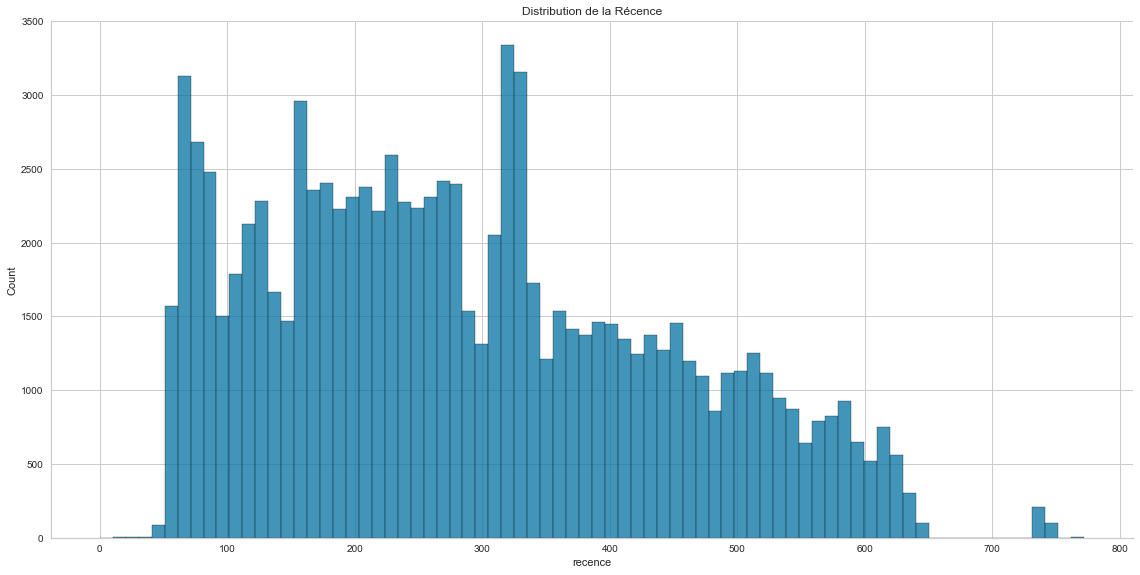

In [6]:
sns.displot(clients, x="recence", height=8, aspect=2).set(
    title='Distribution de la Récence')
plt.show()

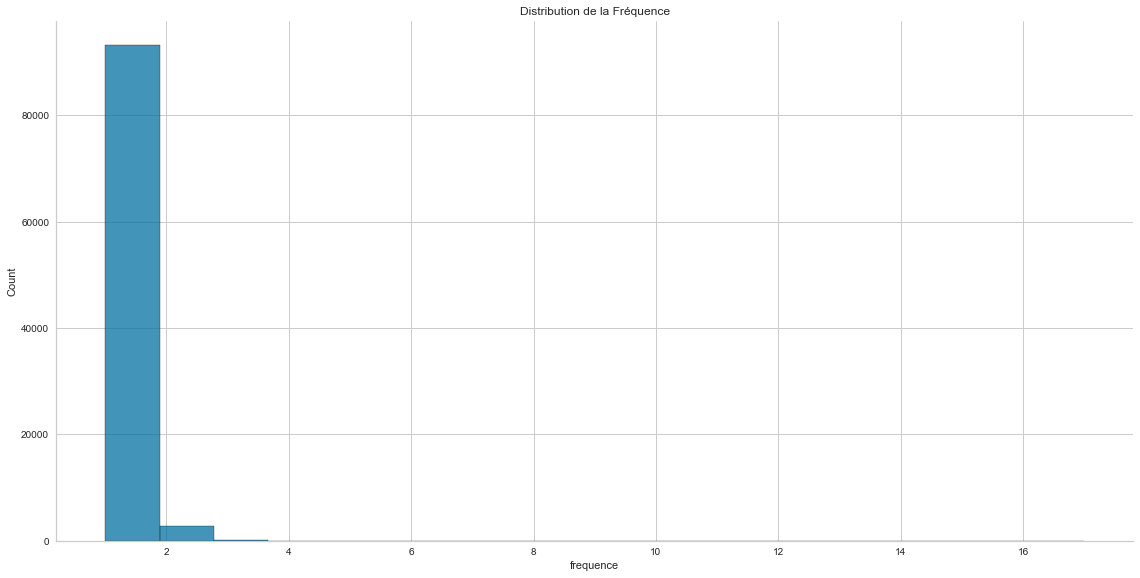

In [7]:
sns.displot(
    clients,
    x="frequence",
    height=8,
    aspect=2
).set(title='Distribution de la Fréquence')
plt.show()

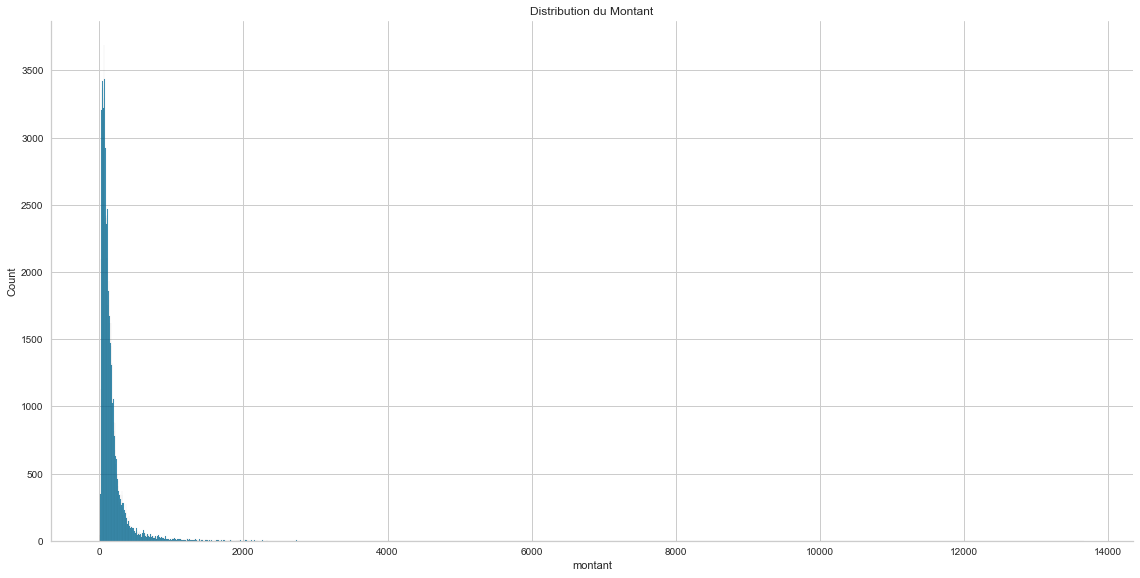

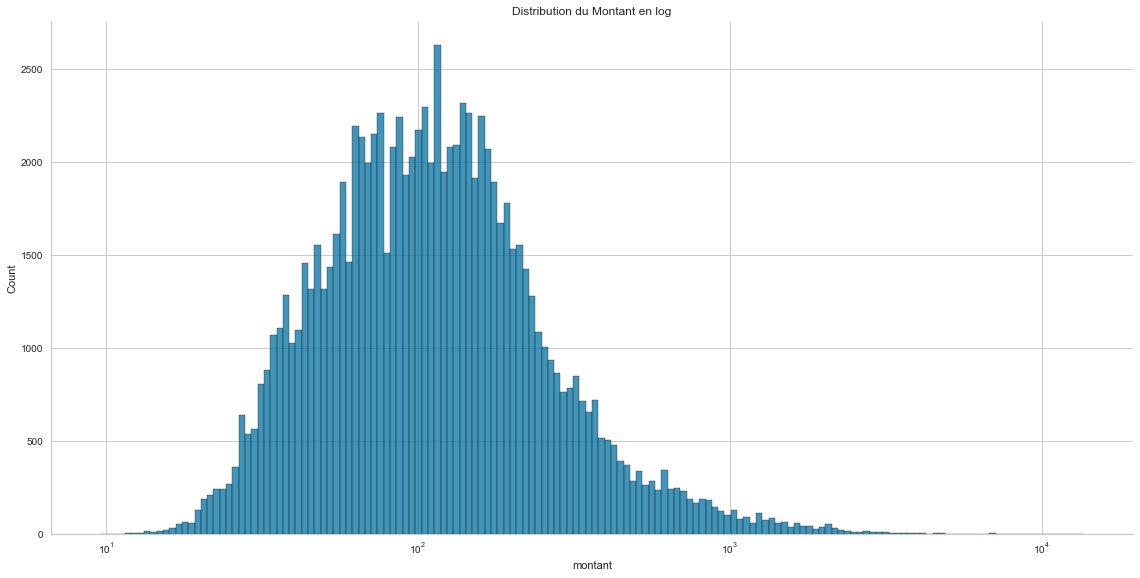

In [8]:
sns.displot(
    clients,
    x="montant",
    height=8,
    aspect=2
).set(title='Distribution du Montant')
sns.displot(
    clients,
    x="montant",
    log_scale=True,
    height=8,
    aspect=2
).set(title='Distribution du Montant en log')
plt.show()

On constate que la Récence est plutôt bien distribuée. Pour la fréquence, il n'y a pas assez de valeurs différentes pour justifier un passage au log. Le passage au log est surtout intéressant pour le Montant, on change donc le contenu de cette colonne.

In [9]:
clients['montant'] = [log(p) for p in clients['montant']]

Standardisation des données clients :

In [10]:
scaler = StandardScaler()
clients_std = scaler.fit_transform(clients)

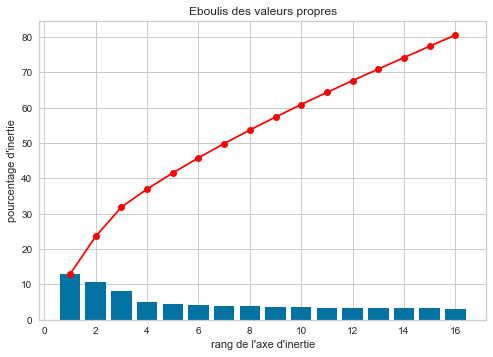

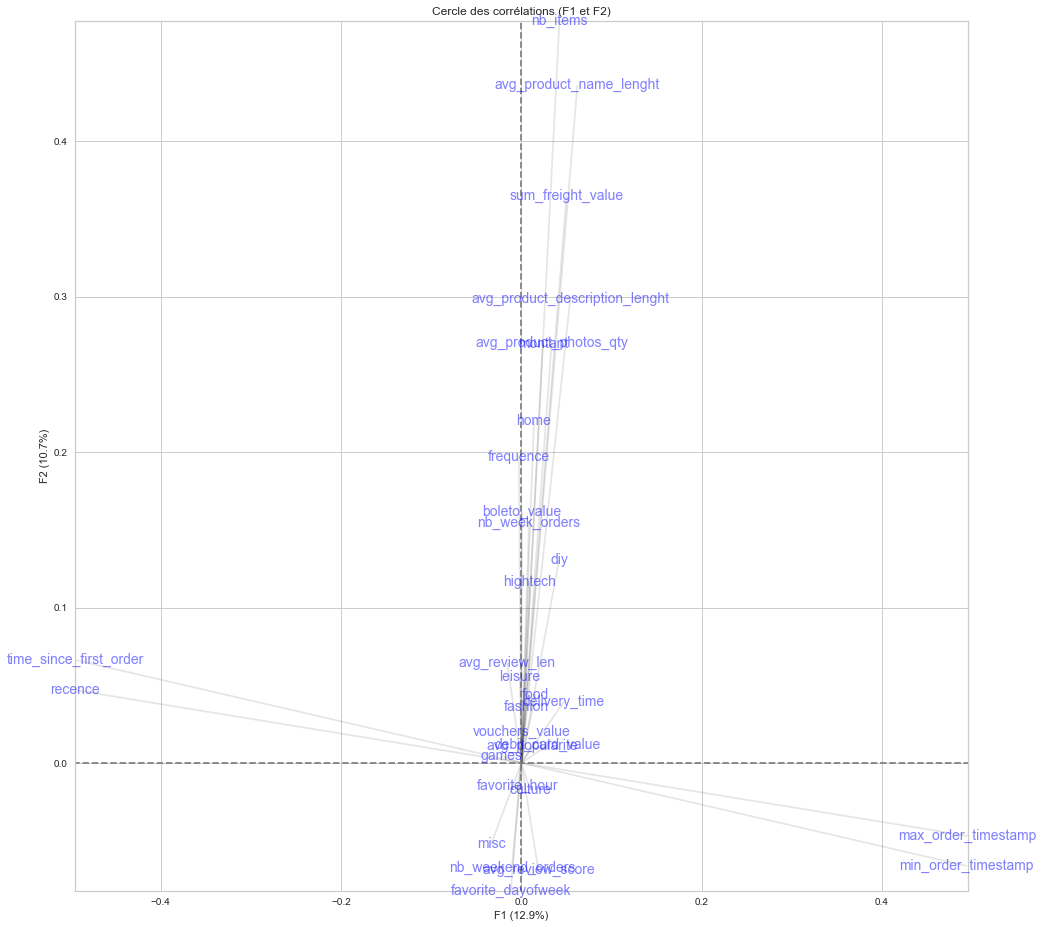

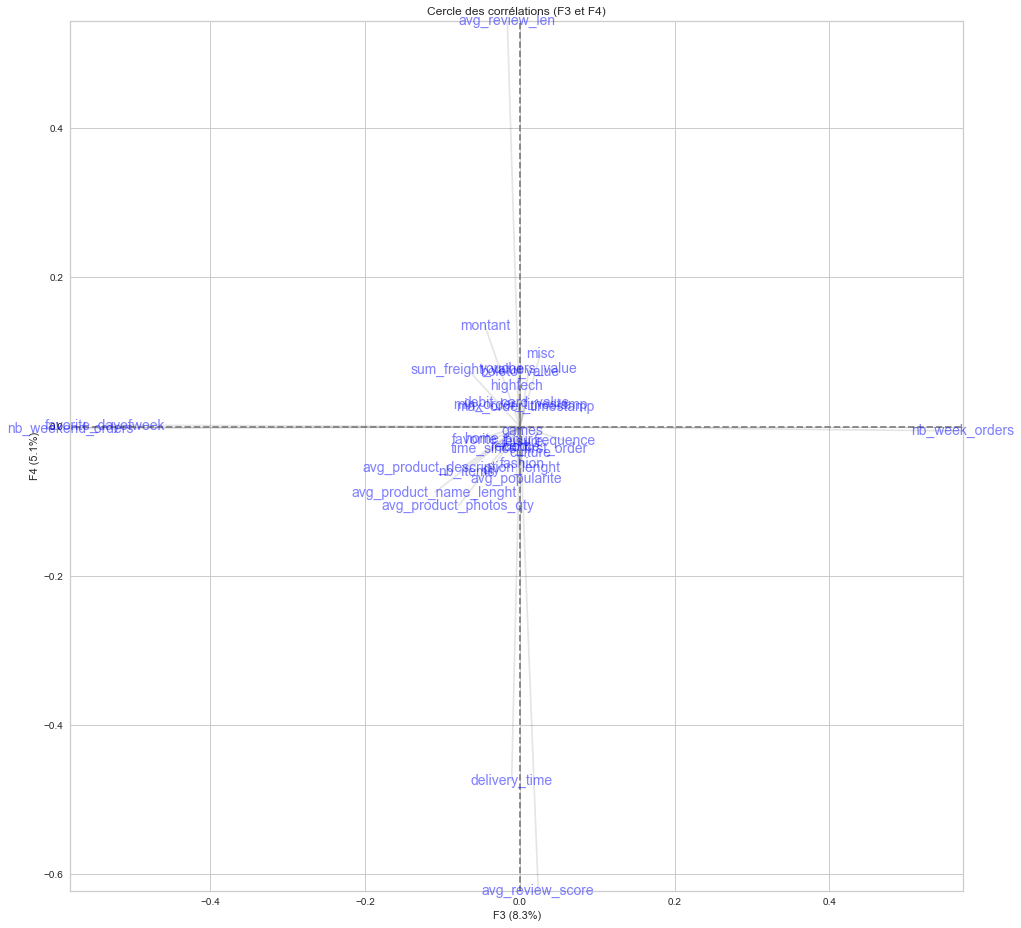

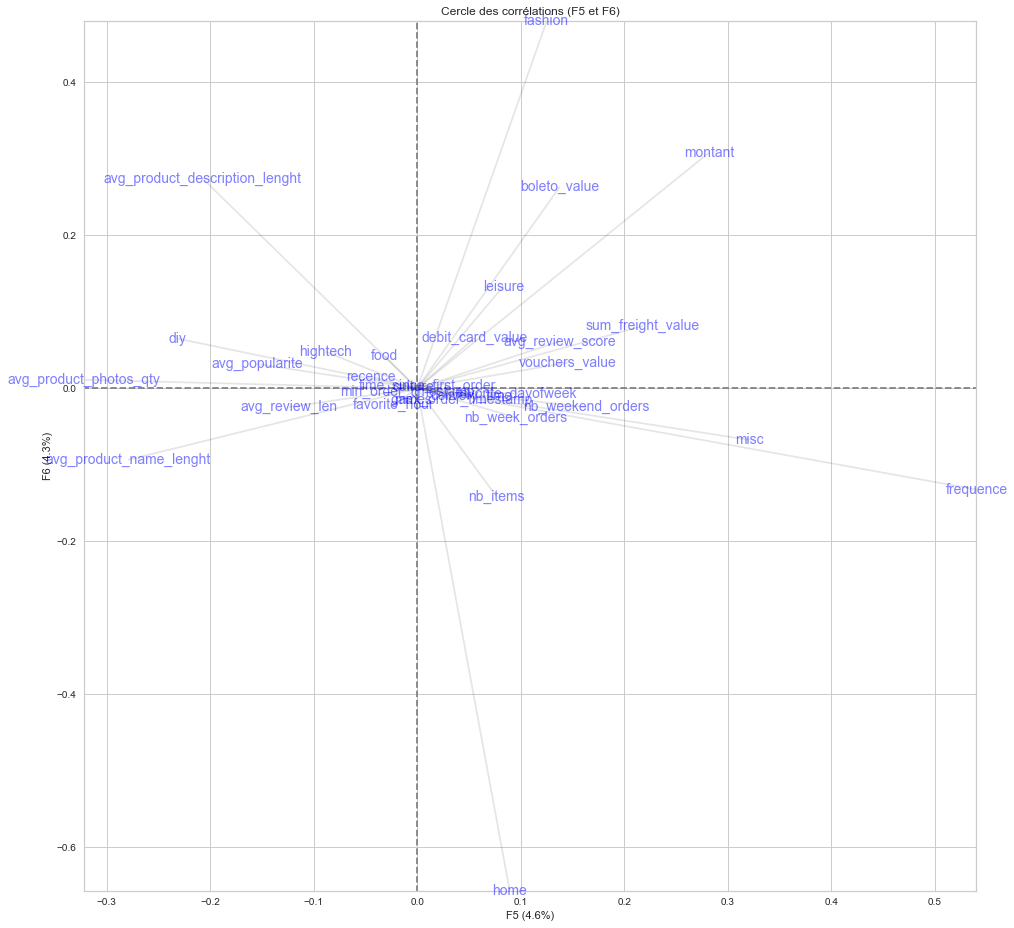

In [11]:
# Ici on ne connait pas le nombre de composantes à calculer,
# on demande à scikit-learn de conserver 80% de la variance.
pca = PCA(0.8)
data_pca = pca.fit_transform(clients_std)

# Eboulis des valeurs propres - on utilise la fonction d'un projet précédent
display_scree_plot(pca)

pcs = pca.components_

n_comp = 6
axis_ranks = [(0, 1), (2, 3), (4, 5)]
labels = np.array(clients.columns)

for d1, d2 in axis_ranks:  # On affiche les premiers plans factoriels
    if d2 < n_comp:

        # initialisation de la figure
        fig, ax = plt.subplots(figsize=(16, 16))

        # détermination des limites du graphique
        if pcs.shape[1] < 30:
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else:
            xmin, xmax, ymin, ymax = min(pcs[d1, :]),\
                                     max(pcs[d1, :]),\
                                     min(pcs[d2, :]),\
                                     max(pcs[d2, :])

        # affichage des flèches
        if pcs.shape[1] < 30:
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1, :], pcs[d2, :],
                       angles='xy', scale_units='xy', scale=1, color="grey")
        else:
            lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
            ax.add_collection(
                LineCollection(lines, axes=ax, alpha=.1, color='black')
            )

        # affichage des noms des variables
        if labels is not None:
            for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', 
                             ha='center', va='center', rotation=0, 
                             color="blue", alpha=0.5)

        # affichage du cercle
        circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
        plt.gca().add_artist(circle)

        # définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        # affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(d1 + 1,
                                      round(100*pca.explained_variance_ratio_[d1], 1)))
        plt.ylabel('F{} ({}%)'.format(d2 + 1,
                                      round(100*pca.explained_variance_ratio_[d2], 1)))

        plt.title("Cercle des corrélations (F{} et F{})".format(d1 + 1, d2 + 1))
        plt.show(block=False)

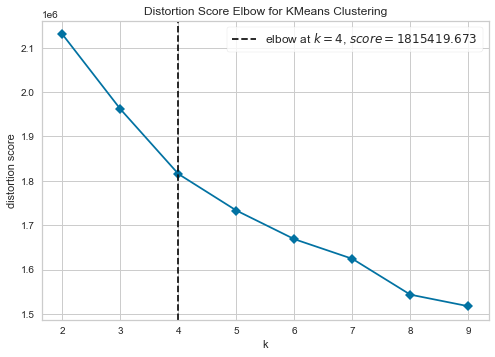

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
clients_cluster = cluster.KMeans()
k_elbow_visualizer = KElbowVisualizer(clients_cluster,
                                      k=(2, 10),
                                      timings=False)
k_elbow_visualizer.fit(data_pca)
k_elbow_visualizer.show()

La méthode du coude nous donne un k optimal pour une valeur de 4.

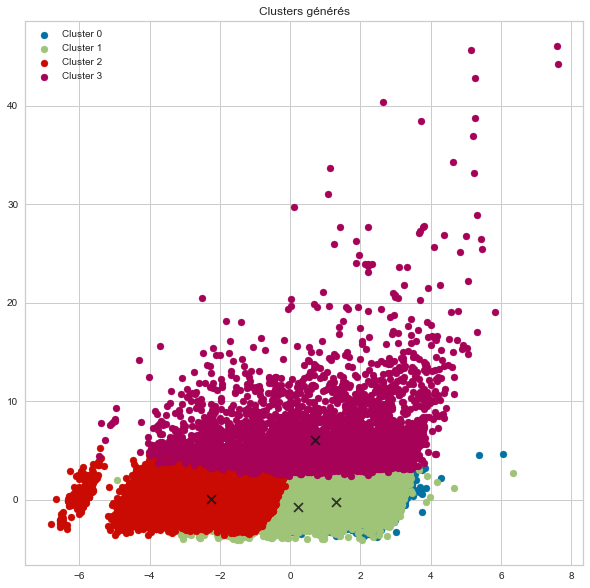

In [13]:
n_clusters = 4
kmeans = cluster.KMeans(n_clusters=n_clusters)
label = kmeans.fit_predict(data_pca)
plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    plt.scatter(data_pca[label == i, 0],
                data_pca[label == i, 1],
                label="Cluster " + str(i))
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            s=80, alpha=0.8, color='k', marker="x")
plt.legend()
plt.title('Clusters générés')
plt.show()

In [14]:
# Le coefficient de silhouette
print("Silhouette Coefficient: %0.3f" %
      sklearn.metrics.silhouette_score(data_pca, kmeans.labels_))

Silhouette Coefficient: 0.162


Ce n'est pas un très bon score de silhouette et d'après le graphique généré, il semble que l'un des clusters ne soit pas très représenté.
Je reprends les traitements en n'utilisant que les 3 colonnes "RFM".

In [15]:
clients_rfm = pd.DataFrame(
    clients[['recence', 'frequence', 'montant']]
)
scaler_rfm = StandardScaler()
clients_rfm_std = scaler_rfm.fit_transform(clients_rfm)

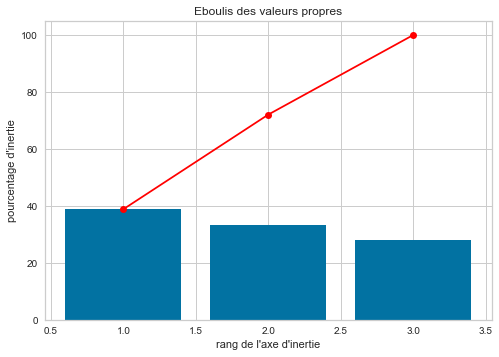

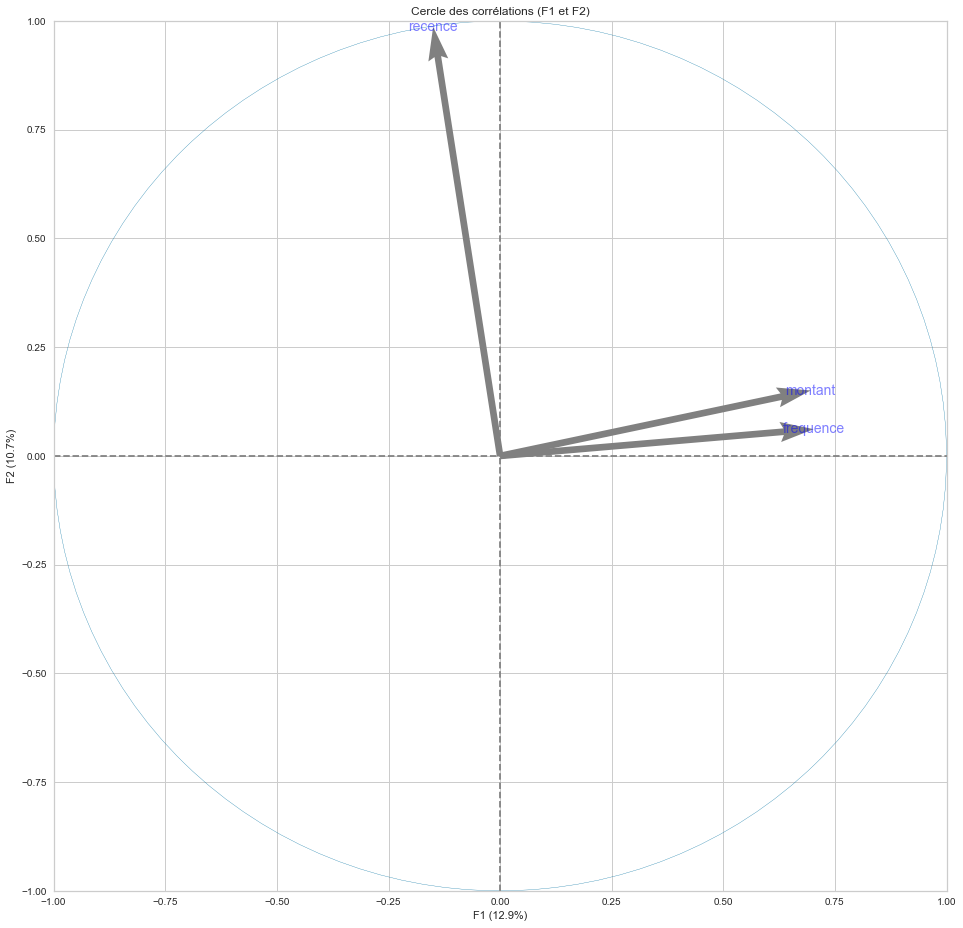

In [16]:
pca_rfm = PCA(0.8)
data_pca_rfm = pca_rfm.fit_transform(clients_rfm_std)

# Eboulis des valeurs propres - on utilise la fonction d'un projet précédent
display_scree_plot(pca_rfm)

pcs_rfm = pca_rfm.components_

n_comp = 2
axis_ranks = [(0, 1)]
labels = np.array(clients_rfm.columns)

for d1, d2 in axis_ranks:  # On affiche les premiers plans factoriels
    if d2 < n_comp:

        # initialisation de la figure
        fig, ax = plt.subplots(figsize=(16, 16))

        # détermination des limites du graphique
        if pcs_rfm.shape[1] < 30 :
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else :
            xmin, xmax, ymin, ymax = min(pcs_rfm[d1,:]),\
                                     max(pcs_rfm[d1,:]),\
                                     min(pcs_rfm[d2,:]),\
                                     max(pcs_rfm[d2,:])

        # affichage des flèches
        if pcs_rfm.shape[1] < 30:
            plt.quiver(np.zeros(pcs_rfm.shape[1]), np.zeros(pcs_rfm.shape[1]),
               pcs_rfm[d1, :], pcs_rfm[d2, :],
               angles='xy', scale_units='xy', scale=1, color="grey")
        else:
            lines = [[[0, 0], [x, y]] for x, y in pcs_rfm[[d1,d2]].T]
            ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

        # affichage des noms des variables  
        if labels is not None:  
            for i, (x, y) in enumerate(pcs_rfm[[d1,d2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14',
                             ha='center', va='center',
                             rotation=0, color="blue", alpha=0.5)

        # affichage du cercle
        circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
        plt.gca().add_artist(circle)

        # définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        # affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(d1 + 1,
                                      round(100*pca.explained_variance_ratio_[d1], 1)))
        plt.ylabel('F{} ({}%)'.format(d2 + 1,
                                      round(100*pca.explained_variance_ratio_[d2], 1)))

        plt.title("Cercle des corrélations (F{} et F{})".format(d1 + 1, d2 + 1))
        plt.show(block=False)

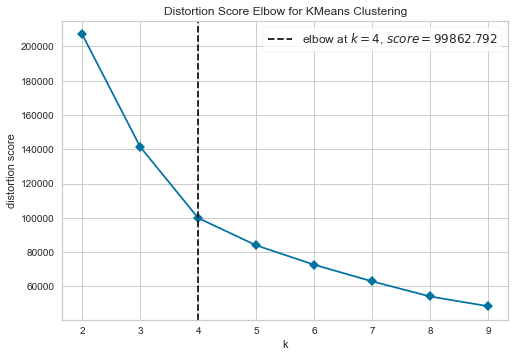

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
cluster_rfm = cluster.KMeans()
k_elbow_visualizer_rfm = KElbowVisualizer(
    cluster_rfm,
    k=(2, 10),
    timings=False
)
k_elbow_visualizer_rfm.fit(data_pca_rfm)
k_elbow_visualizer_rfm.show()

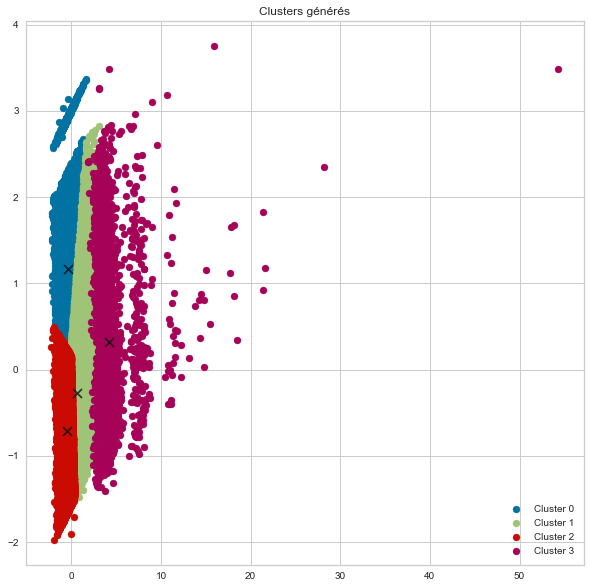

In [18]:
n_clusters = 4
kmeans_rfm = cluster.KMeans(n_clusters=n_clusters)
label_rfm = kmeans_rfm.fit_predict(data_pca_rfm)
cluster_centers_rfm = kmeans_rfm.cluster_centers_
plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    plt.scatter(data_pca_rfm[label_rfm == i, 0],
                data_pca_rfm[label_rfm == i, 1],
                label="Cluster " + str(i))
plt.scatter(cluster_centers_rfm[:, 0],
            cluster_centers_rfm[:, 1],
            s=80, alpha=0.8, color='k', marker="x")
plt.legend()
plt.title('Clusters générés')
plt.show()

On essaie ici d'afficher les 3 variables sur les axes de projection en 3D.

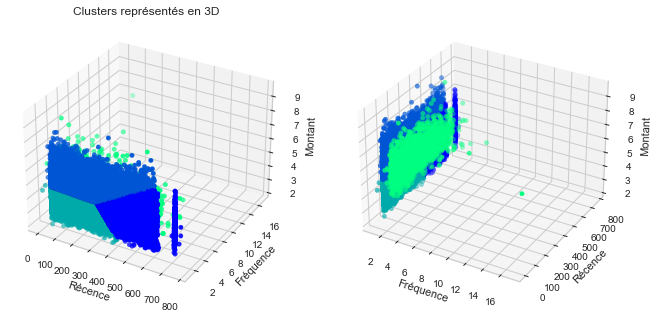

In [19]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(clients_rfm['recence'],
           clients_rfm['frequence'],
           clients_rfm['montant'],
           c=label_rfm, s=20, cmap='winter')
ax.set_title('Clusters représentés en 3D')
ax.set_xlabel('Récence')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Montant')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(clients_rfm['frequence'],
           clients_rfm['recence'],
           clients_rfm['montant'],
           c=label_rfm, s=20, cmap='winter')
ax.set_xlabel('Fréquence')
ax.set_ylabel('Récence')
ax.set_zlabel('Montant')
plt.show()

In [20]:
# Le coefficient de silhouette
print("Silhouette Coefficient: %0.3f" %
      sklearn.metrics.silhouette_score(data_pca_rfm, kmeans_rfm.labels_))

Silhouette Coefficient: 0.367


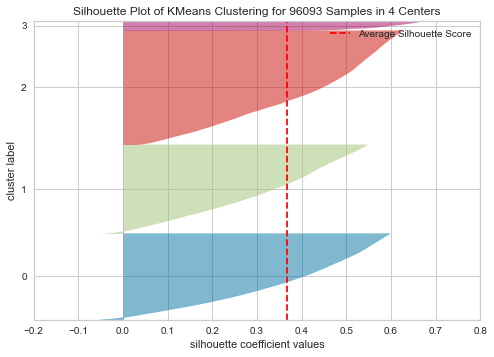

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96093 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans_rfm, colors='yellowbrick')
visualizer.fit(data_pca_rfm)
visualizer.show()

On regarde les moyennes des valeurs utilisées pour la segmentation RFM

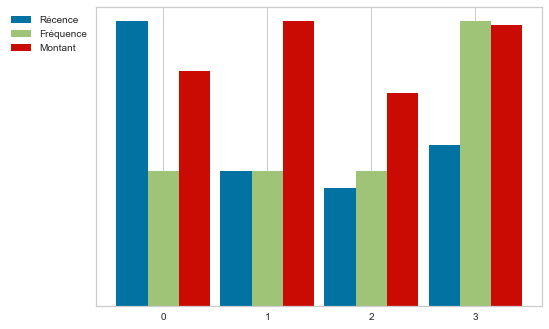

In [22]:
clients_rfm["kmeans_rfm_cluster"] = kmeans_rfm.labels_
clients_rfm_by_cluster = clients_rfm.groupby("kmeans_rfm_cluster")
moyennes_rfm = clients_rfm_by_cluster.mean()

max_moyennes = moyennes_rfm.max()
moyennes_rfm = moyennes_rfm / max_moyennes

# Création de la figure et d'un set de sous-graphiques
position = np.arange(len(moyennes_rfm.index))
largeur = .3
fig, ax = plt.subplots()
r1 = ax.bar(position - largeur,
            moyennes_rfm['recence'],
            largeur,
            label='Récence')
r2 = ax.bar(position,
            moyennes_rfm['frequence'],
            largeur,
            label='Fréquence')
r3 = ax.bar(position + largeur,
            moyennes_rfm['montant'],
            largeur,
            label='Montant')
ax.set_xticks(position)
ax.set_xticklabels(moyennes_rfm.index)
ax.get_yaxis().set_visible(False)
ax.legend(bbox_to_anchor=(0, 1, 0, 0), bbox_transform=ax.transAxes)
plt.show()

Ici, on comprend les caractéristiques des clusters :
- 0 : ancien client
- 1 : client récent, gros montant
- 2 : client récent, petit montant
- 3 : client qui commande souvent

In [23]:
clients_rfm2 = pd.DataFrame(
    clients[['recence', 'frequence', 'montant',
             'nb_items', 'nb_week_orders', 'fashion', 'diy', 'home',
             'hightech', 'culture', 'leisure', 'games', 'food']])
scaler_rfm2 = StandardScaler()
clients_rfm2_std = scaler_rfm2.fit_transform(clients_rfm2)

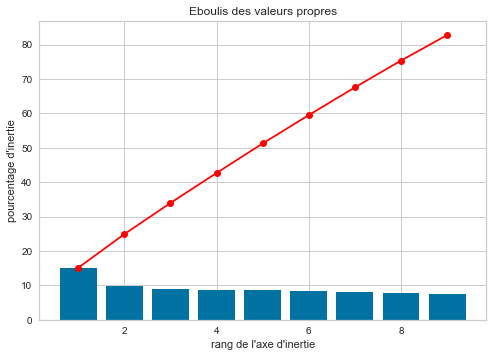

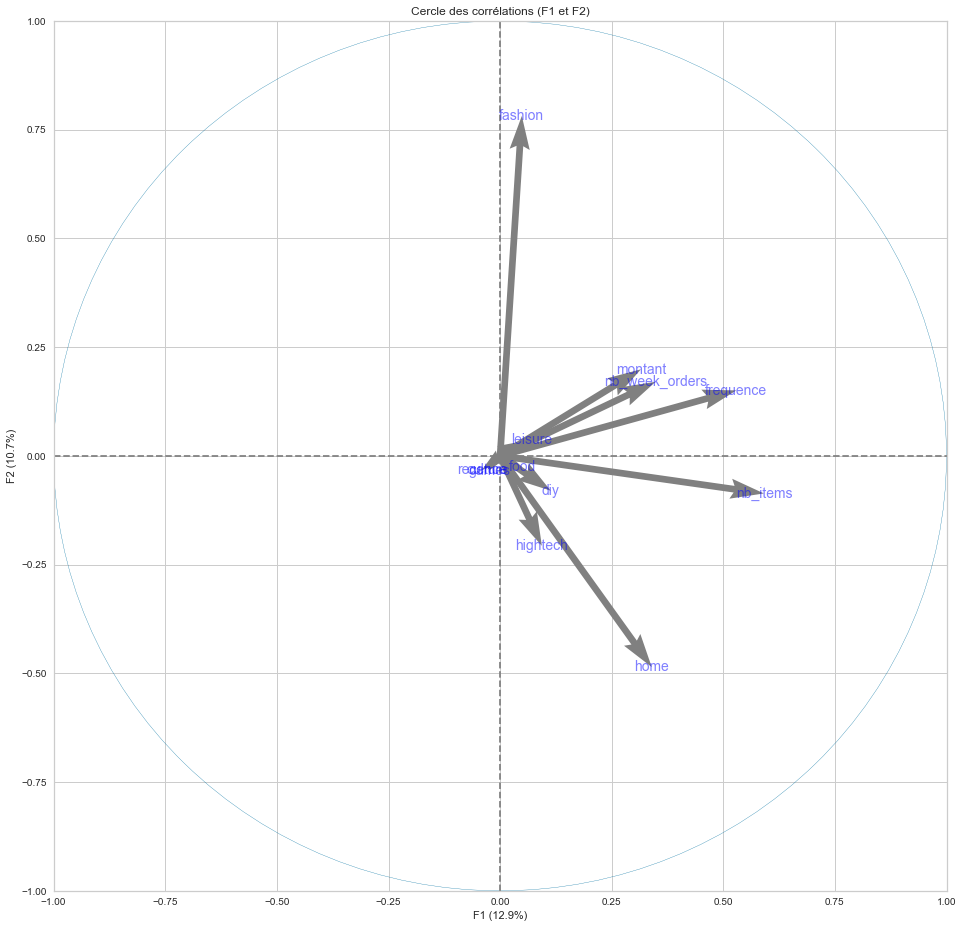

In [24]:
pca_rfm2 = PCA(0.8)
data_pca_rfm2 = pca_rfm2.fit_transform(clients_rfm2_std)

display_scree_plot(pca_rfm2)

pcs_rfm2 = pca_rfm2.components_

n_comp = 2
axis_ranks = [(0, 1)]
labels = np.array(clients_rfm2.columns)

for d1, d2 in axis_ranks:  # On affiche les premiers plans factoriels
    if d2 < n_comp:

        # initialisation de la figure
        fig, ax = plt.subplots(figsize=(16, 16))

        # détermination des limites du graphique
        if pcs_rfm2.shape[1] < 30 :
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else :
            xmin, xmax, ymin, ymax = min(pcs_rfm2[d1,:]), max(pcs_rfm2[d1,:]), min(pcs_rfm2[d2,:]), max(pcs_rfm2[d2,:])

        # affichage des flèches
        if pcs_rfm2.shape[1] < 30 :
            plt.quiver(np.zeros(pcs_rfm2.shape[1]), np.zeros(pcs_rfm2.shape[1]),
               pcs_rfm2[d1,:], pcs_rfm2[d2,:], 
               angles='xy', scale_units='xy', scale=1, color="grey")
        else:
            lines = [[[0,0],[x,y]] for x,y in pcs_rfm2[[d1,d2]].T]
            ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

        # affichage des noms des variables  
        if labels is not None:  
            for i,(x, y) in enumerate(pcs_rfm2[[d1,d2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=0, color="blue", alpha=0.5)

        # affichage du cercle
        circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
        plt.gca().add_artist(circle)

        # définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        # affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
        plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

        plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
        plt.show(block=False)

C:\anaconda\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\anaconda\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


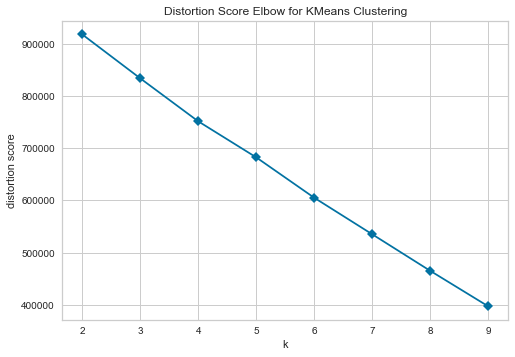

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
cluster_rfm2 = cluster.KMeans()
k_elbow_visualizer_rfm2 = KElbowVisualizer(
    cluster_rfm2,
    k=(2, 10),
    timings=False
)
k_elbow_visualizer_rfm2.fit(data_pca_rfm2)
k_elbow_visualizer_rfm2.show()

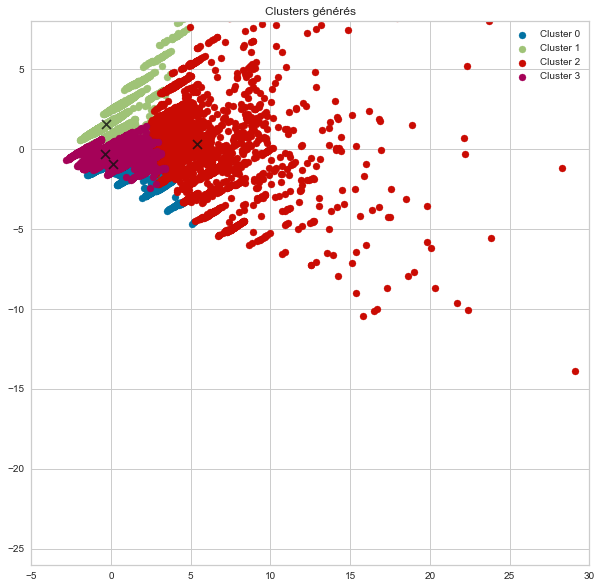

In [26]:
n_clusters = 4
kmeans_rfm2 = cluster.KMeans(n_clusters=n_clusters)
label_rfm2 = kmeans_rfm2.fit_predict(data_pca_rfm2)
cluster_centers_rfm2 = kmeans_rfm2.cluster_centers_
plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    plt.scatter(data_pca_rfm2[label_rfm2 == i, 0],
                data_pca_rfm2[label_rfm2 == i, 1],
                label="Cluster " + str(i))
plt.scatter(cluster_centers_rfm2[:, 0],
            cluster_centers_rfm2[:, 1],
            s=80, alpha=0.8, color='k', marker="x")
plt.legend()
plt.title('Clusters générés')
plt.xlim(left=-5, right=30)
plt.ylim(top=8, bottom=-26)
plt.show()

In [27]:
# Le coefficient de silhouette
print("Silhouette Coefficient: %0.3f" %
      sklearn.metrics.silhouette_score(data_pca_rfm2, kmeans_rfm2.labels_))

Silhouette Coefficient: 0.209


In [28]:
clients_rfm3 = pd.DataFrame(
    clients[['recence', 'frequence', 'montant',
             'avg_review_score']])
scaler_rfm3 = StandardScaler()
clients_rfm3_std = scaler_rfm3.fit_transform(clients_rfm3)

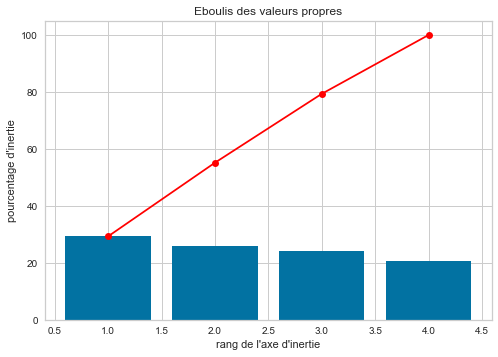

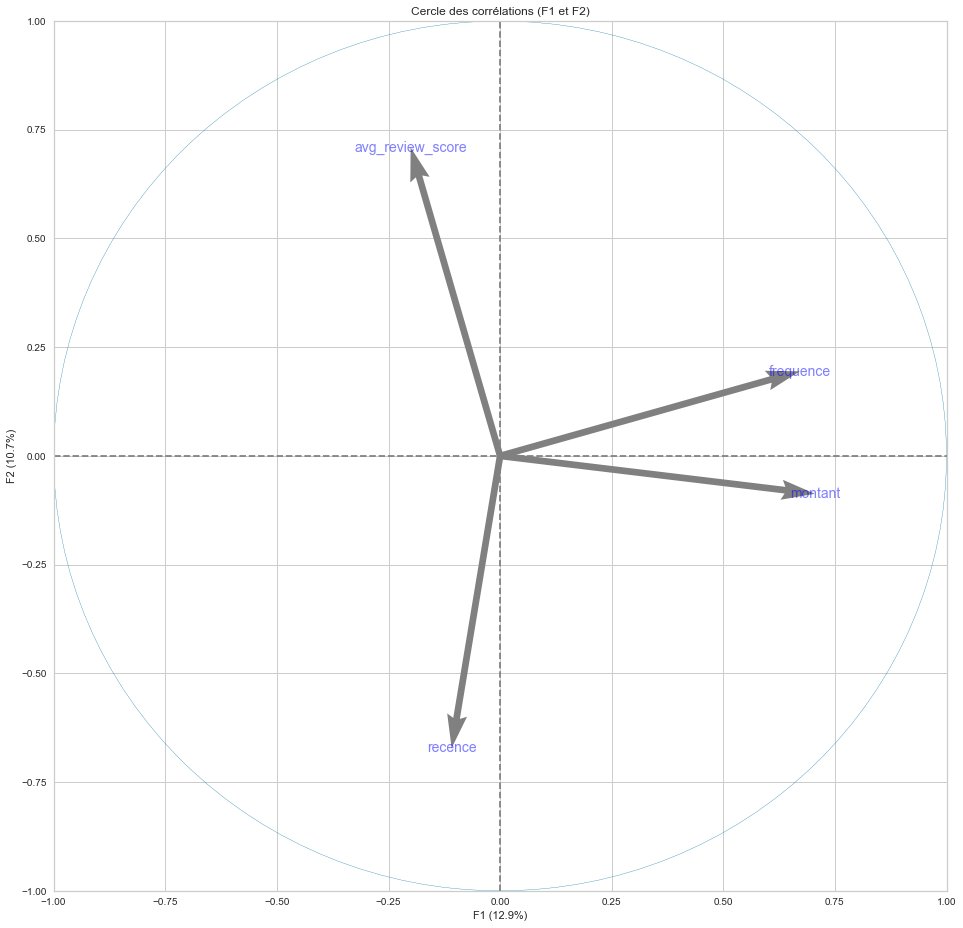

In [29]:
pca_rfm3 = PCA(0.8)
data_pca_rfm3 = pca_rfm3.fit_transform(clients_rfm3_std)

display_scree_plot(pca_rfm3)

pcs_rfm3 = pca_rfm3.components_

n_comp = 2
axis_ranks = [(0, 1)]
labels = np.array(clients_rfm3.columns)

for d1, d2 in axis_ranks:  # On affiche les premiers plans factoriels
    if d2 < n_comp:

        # initialisation de la figure
        fig, ax = plt.subplots(figsize=(16, 16))

        # détermination des limites du graphique
        if pcs_rfm3.shape[1] < 30:
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else :
            xmin, xmax, ymin, ymax = min(pcs_rfm3[d1, :]),\
                                     max(pcs_rfm3[d1, :]),\
                                     min(pcs_rfm3[d2, :]),\
                                     max(pcs_rfm3[d2, :])

        # affichage des flèches
        if pcs_rfm3.shape[1] < 30 :
            plt.quiver(np.zeros(pcs_rfm3.shape[1]),
                       np.zeros(pcs_rfm3.shape[1]),
                       pcs_rfm3[d1, :],
                       pcs_rfm3[d2, :], 
                       angles='xy', scale_units='xy',
                       scale=1, color="grey")
        else:
            lines = [[[0, 0], [x, y]] for x, y in pcs_rfm3[[d1, d2]].T]
            ax.add_collection(
                LineCollection(lines, axes=ax, alpha=.1, color='black')
            )

        # affichage des noms des variables  
        if labels is not None:  
            for i, (x, y) in enumerate(pcs_rfm3[[d1, d2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14',
                             ha='center', va='center',
                             rotation=0, color="blue", alpha=0.5)

        # affichage du cercle
        circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
        plt.gca().add_artist(circle)

        # définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        # affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(
            d1 + 1,
            round(100 * pca.explained_variance_ratio_[d1], 1))
                  )
        plt.ylabel('F{} ({}%)'.format(
            d2 + 1,
            round(100 * pca.explained_variance_ratio_[d2], 1)))

        plt.title("Cercle des corrélations (F{} et F{})".format(
            d1 + 1, d2 + 1
        ))
        plt.show(block=False)

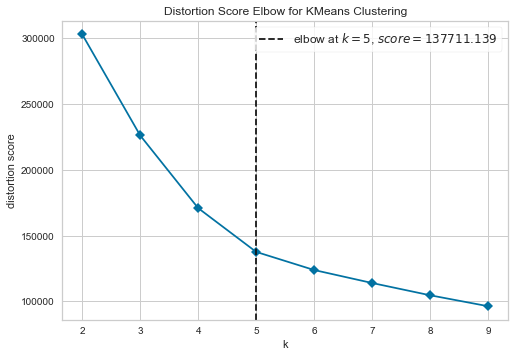

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
cluster_rfm3 = cluster.KMeans()
k_elbow_visualizer_rfm3 = KElbowVisualizer(
    cluster_rfm3,
    k=(2, 10),
    timings=False
)
k_elbow_visualizer_rfm3.fit(data_pca_rfm3)
k_elbow_visualizer_rfm3.show()

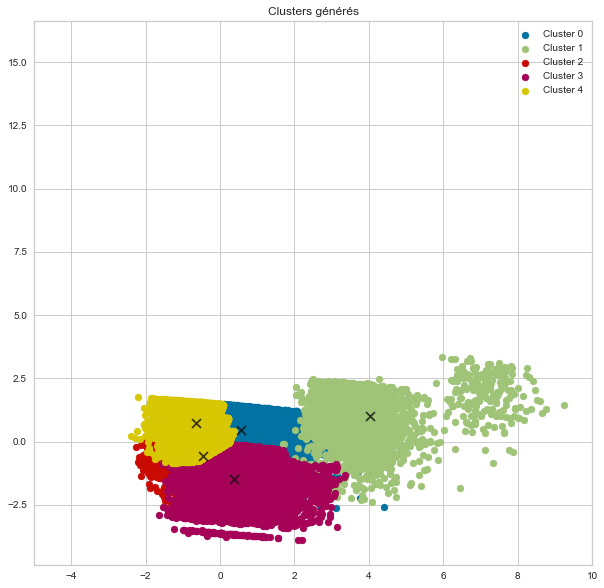

In [31]:
n_clusters = 5
kmeans_rfm3 = cluster.KMeans(n_clusters=n_clusters)
label_rfm3 = kmeans_rfm3.fit_predict(data_pca_rfm3)
cluster_centers_rfm3 = kmeans_rfm3.cluster_centers_
plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    plt.scatter(data_pca_rfm3[label_rfm3 == i, 0],
                data_pca_rfm3[label_rfm3 == i, 1],
                label="Cluster " + str(i))
plt.scatter(cluster_centers_rfm3[:, 0],
            cluster_centers_rfm3[:, 1],
            s=80, alpha=0.8, color='k', marker="x")
plt.legend()
plt.title('Clusters générés')
plt.xlim(left=-5, right=10)
plt.show()

In [32]:
# Le coefficient de silhouette
print("Silhouette Coefficient: %0.3f" %
      sklearn.metrics.silhouette_score(data_pca_rfm3, kmeans_rfm3.labels_))

Silhouette Coefficient: 0.318


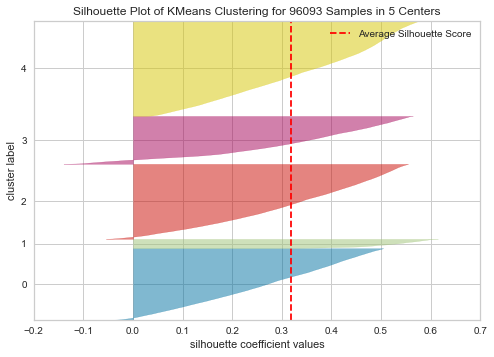

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96093 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans_rfm3, colors='yellowbrick')
visualizer.fit(data_pca_rfm3)
visualizer.show()

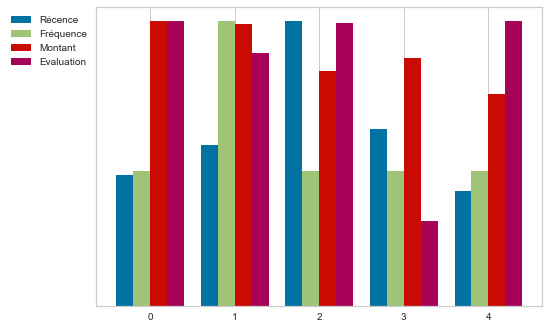

In [34]:
clients_rfm3["kmeans_rfm_cluster"] = kmeans_rfm3.labels_
clients_rfm3_by_cluster = clients_rfm3.groupby("kmeans_rfm_cluster")
moyennes_rfm3 = clients_rfm3_by_cluster.mean()

max_moyennes3 = moyennes_rfm3.max()
moyennes_rfm3 = moyennes_rfm3 / max_moyennes3

# Création de la figure et d'un set de sous-graphiques
position = np.arange(len(moyennes_rfm3.index))
largeur = .2
fig, ax = plt.subplots()
r1 = ax.bar(position - 1.5*largeur,
            moyennes_rfm3['recence'],
            largeur,
            label='Récence')
r2 = ax.bar(position - 0.5*largeur,
            moyennes_rfm3['frequence'],
            largeur,
            label='Fréquence')
r3 = ax.bar(position + 0.5*largeur,
            moyennes_rfm3['montant'],
            largeur,
            label='Montant')
r4 = ax.bar(position + 1.5*largeur,
            moyennes_rfm3['avg_review_score'],
            largeur,
            label='Evaluation')
ax.set_xticks(position)
ax.set_xticklabels(moyennes_rfm3.index)
ax.get_yaxis().set_visible(False)
ax.legend(bbox_to_anchor=(0, 1, 0, 0), bbox_transform=ax.transAxes)
plt.show()

In [39]:
# on augmente de 30 jours la temporalité de nos données,
# 12 fois (soit environ 1 an)
for i in range(1, 13):
    clients_rfm['recence'] = clients_rfm['recence'] + i * 30
    clients_rfm_std = scaler_rfm.transform(
        clients_rfm[['recence', 'frequence', 'montant']]
    )
    data_pca_rfm = pca_rfm.transform(clients_rfm_std)
    label_rfm = kmeans_rfm.predict(data_pca_rfm)
    clients_rfm["kmeans_rfm_cluster_" + str(i)] = label_rfm

In [40]:
clients_rfm.rename(columns={
                        'kmeans_rfm_cluster': 'kmeans_rfm_cluster_0'
                    }, inplace=True)

In [41]:
positions = np.array(['kmeans_rfm_cluster_' + str(p) for p in range(13)])
clients_rfm[positions]

,kmeans_rfm_cluster_0,kmeans_rfm_cluster_1,kmeans_rfm_cluster_2,kmeans_rfm_cluster_3,kmeans_rfm_cluster_4,kmeans_rfm_cluster_5,kmeans_rfm_cluster_6,kmeans_rfm_cluster_7,kmeans_rfm_cluster_8,kmeans_rfm_cluster_9,kmeans_rfm_cluster_10,kmeans_rfm_cluster_11,kmeans_rfm_cluster_12
0,1,1,1,0,0,0,0,0,0,0,0,0,0
1,2,2,2,2,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96088,1,1,1,1,0,0,0,0,0,0,0,0,0
96089,2,0,0,0,0,0,0,0,0,0,0,0,0
96090,0,0,0,0,0,0,0,0,0,0,0,0,0
96091,1,1,1,0,0,0,0,0,0,0,0,0,0


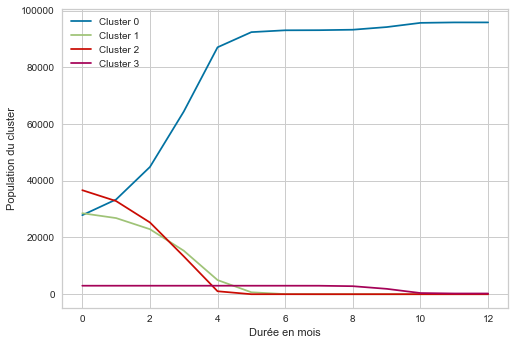

In [46]:
counts_array = {}
for i in np.arange(len(moyennes_rfm.index)):
    counts_array[i] = []
for c in positions:
    counts = clients_rfm.value_counts(subset=[c])
    for i in np.arange(len(moyennes_rfm.index)):
        if i not in counts.keys():
            counts_array[i].append(0)
        else:
            counts_array[i].append(counts[i])

# Courbes
for i in counts_array.keys():
    plt.plot(counts_array[i], label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Durée en mois')
plt.ylabel('Population du cluster')
plt.show()

C:\anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
C:\anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
C:\anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered i

ARI 1 mois : -79.14971315150562
ARI 2 mois : -18.307005358270324
ARI 3 mois : 1.378514642705499
ARI 4 mois : -1.42240473963668
ARI 5 mois : 7.646988851102375
ARI 6 mois : 3.939774705703473
ARI 7 mois : 3.824441674281984
ARI 8 mois : 3.228914002622343
ARI 9 mois : 1.3271415232916262
ARI 10 mois : 0.17309312419603912
ARI 11 mois : 0.1012532747884434
ARI 12 mois : 0.1012532747884434


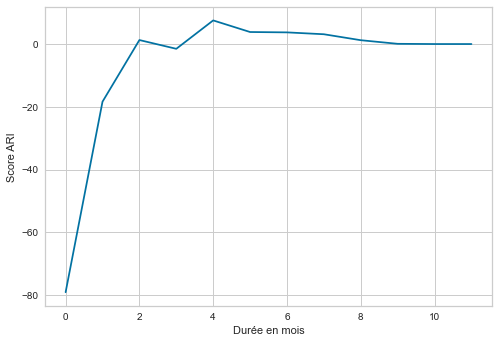

In [48]:
from sklearn.metrics import adjusted_rand_score
aris = []
for i in range(1, 13):
    ari = adjusted_rand_score(
        clients_rfm['kmeans_rfm_cluster_0'],
        clients_rfm['kmeans_rfm_cluster_' + str(i)]
    )
    aris.append(ari)
    print("ARI", i, "mois :", ari)
plt.plot(aris)
plt.xlabel('Durée en mois')
plt.ylabel('Score ARI')
plt.show()

Pour une meilleure vérification de la stabilité d'un modèle, j'ai généré de nouveaux fichiers de données, afin de ne prendre en compte qu'un an de commandes, en ayant des données glissantes sur 14 mois.
J'entraine mon meilleur modèle (RFM simple) sur le premier segment des données et je l'exécute à nouveau sur les segments suivants.

In [ ]:
clients['time_since_first_order'].max()

In [ ]:
# Lecture du fichier
clients = pd.read_csv("client_infos_0.csv")

# Passage au log pour le montant
clients.drop(clients.loc[clients['montant'] == 0].index,
             inplace=True)
clients['montant'] = [log(p) for p in clients['montant']]

# On récupère les colonnes utilisées pour la segmentation RFM
clients_rfm = pd.DataFrame(clients[['recence',
                                    'frequence', 'montant']])
# On standardise les données
scaler_rfm = StandardScaler()
clients_rfm_std = scaler_rfm.fit_transform(clients_rfm)

# PCA
pca_rfm = PCA(0.8)
data_pca_rfm = pca_rfm.fit_transform(clients_rfm_std)

# KMeans
n_clusters = 4
kmeans_rfm = cluster.KMeans(n_clusters=n_clusters)
label = kmeans_rfm.fit_predict(data_pca_rfm)

# Graphique des clusters
plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    plt.scatter(data_pca_rfm[label == i, 0],
                data_pca_rfm[label == i, 1],
                label="Cluster " + str(i))
plt.scatter(kmeans_rfm.cluster_centers_[:, 0],
            kmeans_rfm.cluster_centers_[:, 1],
            s=80, alpha=0.8, color='k', marker="x")
plt.legend()
plt.title('Clusters générés')
plt.show()

# Coefficient de silhouette
print("Silhouette Coefficient: %0.3f" %
      sklearn.metrics.silhouette_score(data_pca_rfm, kmeans_rfm.labels_))
visualizer = SilhouetteVisualizer(kmeans_rfm, colors='yellowbrick')
visualizer.fit(data_pca_rfm)
visualizer.show()

# Graphique des moyennes RFM par cluster
clients_rfm["kmeans_rfm_cluster"] = kmeans_rfm.labels_
clients_rfm_by_cluster = clients_rfm.groupby("kmeans_rfm_cluster")
moyennes_rfm = clients_rfm_by_cluster.mean()
max_moyennes = moyennes_rfm.max()
moyennes_rfm = moyennes_rfm / max_moyennes
position = np.arange(len(moyennes_rfm.index))
largeur = .3
fig, ax = plt.subplots()
r1 = ax.bar(position - largeur,
            moyennes_rfm['recence'],
            largeur,
            label='Récence')
r2 = ax.bar(position,
            moyennes_rfm['frequence'],
            largeur,
            label='Fréquence')
r3 = ax.bar(position + largeur,
            moyennes_rfm['montant'],
            largeur,
            label='Montant')
ax.set_xticks(position)
ax.set_xticklabels(moyennes_rfm.index)
ax.get_yaxis().set_visible(False)
ax.legend(bbox_to_anchor=(0, 1, 0, 0),
          bbox_transform=ax.transAxes)
plt.show()

In [ ]:
aris = []
counts_array = {}
for i in range(n_clusters):
    counts_array[i] = []

for i in range(1, 14):
    print("*********** i =", i, "***********")
    clients = pd.read_csv("client_infos_" + str(i) + ".csv")
    clients.drop(clients.loc[clients['montant'] == 0].index,
                 inplace=True)
    clients['montant'] = [log(p) for p in clients['montant']]
    clients_rfm = pd.DataFrame(clients[['recence',
                                        'frequence', 'montant']])
    clients_rfm_std = scaler_rfm.transform(clients_rfm)
    data_pca_rfm = pca_rfm.transform(clients_rfm_std)
    label = kmeans_rfm.predict(data_pca_rfm)
    counts = clients_rfm.value_counts(subset=label)
    for c in range(n_clusters):
        if c in counts.keys():
            counts_array[c].append(counts[c])
        else:
            counts_array[c].append(0)
    plt.figure(figsize=(10, 10))
    for n in range(n_clusters):
        plt.scatter(data_pca_rfm[label == n, 0],
                    data_pca_rfm[label == n, 1],
                    label="Cluster " + str(n))
    plt.scatter(kmeans_rfm.cluster_centers_[:, 0],
                kmeans_rfm.cluster_centers_[:, 1],
                s=80, alpha=0.8, color='k', marker="x")
    plt.legend()
    plt.title('Clusters générés')
    plt.show()
    clients_rfm["kmeans_rfm_cluster"] = label
    clients_rfm_by_cluster = clients_rfm.groupby("kmeans_rfm_cluster")
    moyennes_rfm = clients_rfm_by_cluster.mean()
    max_moyennes = moyennes_rfm.max()
    moyennes_rfm = moyennes_rfm / max_moyennes
    position = np.arange(len(moyennes_rfm.index))
    largeur = .3
    fig, ax = plt.subplots()
    r1 = ax.bar(position - largeur,
                moyennes_rfm['recence'],
                largeur,
                label='Récence')
    r2 = ax.bar(position,
                moyennes_rfm['frequence'],
                largeur,
                label='Fréquence')
    r3 = ax.bar(position + largeur,
                moyennes_rfm['montant'],
                largeur,
                label='Montant')
    ax.set_xticks(position)
    ax.set_xticklabels(moyennes_rfm.index)
    ax.get_yaxis().set_visible(False)
    ax.legend(bbox_to_anchor=(0, 1, 0, 0),
              bbox_transform=ax.transAxes)
    plt.show()

In [ ]:
# Courbes
for i in counts_array.keys():
    plt.plot(counts_array[i], label='Cluster ' + str(i))
plt.legend()
plt.xlabel('Durée en mois')
plt.ylabel('Population du cluster')
plt.show()